##  Simple Transport between graphs using FGW

This notebook proposes to compute the assignment of labeled graphs using FGW

In [1]:
import numpy as np
import os,sys
sys.path.append(os.path.realpath('../lib'))
from graph import graph_colors,draw_rel,draw_transp,Graph,wl_labeling
from ot_distances import Fused_Gromov_Wasserstein_distance,Wasserstein_distance
import copy
from data_loader import load_local_data,histog,build_noisy_circular_graph
import matplotlib.pyplot as plt
import networkx as nx

First example is a transport between two simple graphs with four nodes

In [2]:
g1=Graph()
g1.add_attibutes({0:1,1:7,2:1,3:7})
g1.add_edge((0,1))
g1.add_edge((1,2))
g1.add_edge((3,0))
g1.add_edge((3,2))
g1.add_edge((0,2))
g2=Graph()
g2.add_attibutes({0:7,1:1,2:7,3:1})
g2.add_edge((0,1))
g2.add_edge((1,2))
g2.add_edge((3,0))
g2.add_edge((3,2))
g2.add_edge((2,0))

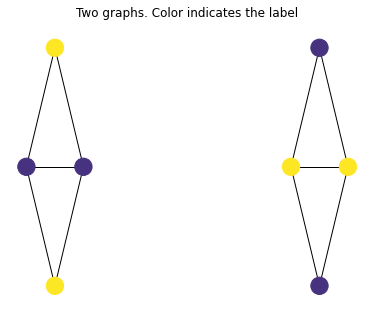

In [3]:
plt.figure(figsize=(5,4))
vmin=0
vmax=7
draw_rel(g1.nx_graph,draw=False,vmin=vmin,vmax=vmax,with_labels=False)
draw_rel(g2.nx_graph,draw=False,vmin=vmin,vmax=vmax,with_labels=False,shiftx=5,swipy=True)
plt.title('Two graphs. Color indicates the label')
plt.show()

In [4]:
alpha=0.5
dfgw=Fused_Gromov_Wasserstein_distance(alpha=alpha,features_metric='dirac',method='shortest_path').graph_d(g1,g2)
dw=Wasserstein_distance(features_metric='dirac').graph_d(g1,g2)
dgw=Fused_Gromov_Wasserstein_distance(alpha=1,features_metric='dirac',method='shortest_path').graph_d(g1,g2)
print('Wasserstein distance={}, Gromov distance={} \nFused Gromov-Wasserstein distance for alpha {} = {}'.format(dw,dgw,alpha,dfgw))

Wasserstein distance=0.0, Gromov distance=1.3749500968472382e-12 
Fused Gromov-Wasserstein distance for alpha 0.5 = 0.12500000000074993


We see that neither Wasserstein distance on the label, or Gromov distance can discriminate between this two graphs, whereas FGW does not vanish.

We now build more complicated graphs with the following :

In [5]:
def build_comunity_graph(N=30,mu=0,sigma=0.3,pw=0.8):
    v=mu+sigma*np.random.randn(N);
    g=Graph()
    g.add_nodes(list(range(N)))
    for i in range(N):
         g.add_one_attribute(i,v[i])
         for j in range(N):
             r=np.random.rand()
             if  r<pw:
                 g.add_edge((i,j))
    return g


In [6]:
N=5
mu1=-1.5
mu2=1.5
vmin=-3
vmax=2
np.random.seed(12)
g1=build_comunity_graph(N=N,mu=mu1,sigma=0.8,pw=0.5)
g2=build_comunity_graph(N=N,mu=mu2,sigma=0.8,pw=0.5)

In [7]:
def merge_graph(g1,g2):
    gprime=nx.Graph(g1)
    N0=len(gprime.nodes())
    g2relabel=nx.relabel_nodes(g2, lambda x: x +N0)
    gprime.add_nodes_from(g2relabel.nodes(data=True))
    gprime.add_edges_from(g2relabel.edges(data=True)) 
    gprime.add_edge(N0-1,N0)
    
    return gprime

In [8]:
g3=merge_graph(merge_graph(g1.nx_graph,merge_graph(g1.nx_graph,g2.nx_graph)),g2.nx_graph)

In [9]:
g4=merge_graph(merge_graph(g2.nx_graph,merge_graph(g1.nx_graph,g2.nx_graph)),g1.nx_graph)

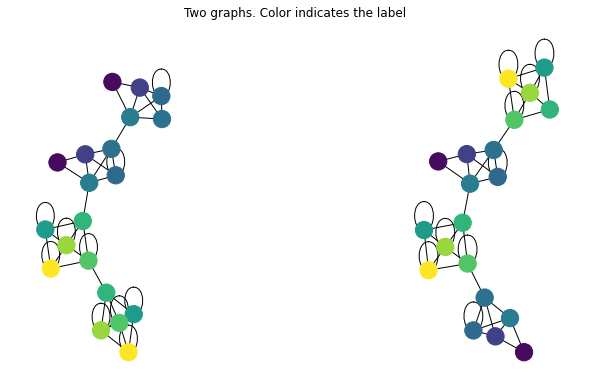

In [10]:
plt.figure(figsize=(8,5))
draw_rel(g3,vmin=vmin,vmax=vmax,with_labels=False,draw=False)
draw_rel(g4,vmin=vmin,vmax=vmax,with_labels=False,shiftx=3,draw=False)
plt.title('Two graphs. Color indicates the label')
plt.show()

This graphs are based on connected communities that are permuted 

In [11]:
G1=Graph(g3)
G2=Graph(g4)

We plot the evolution of the FGW distance with respect to the alpha parameter

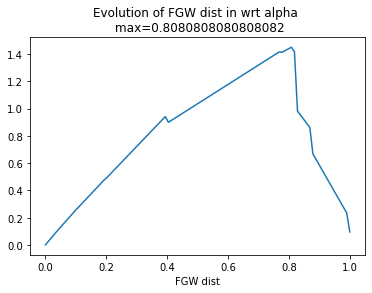

In [12]:
alld=[]
x=np.linspace(0,1,100)
for alpha in x:
    d=Fused_Gromov_Wasserstein_distance(alpha=alpha,features_metric='sqeuclidean').graph_d(G1,G2)
    alld.append(d)
plt.plot(x,alld)
plt.title('Evolution of FGW dist in wrt alpha \n max={}'.format(x[np.argmax(alld)]))
plt.xlabel('Alpha')
plt.xlabel('FGW dist')
plt.show()

We see that the alpha which leads to best discriminate the graphs is between 0 and 1. We plot the coupling using this alpha :

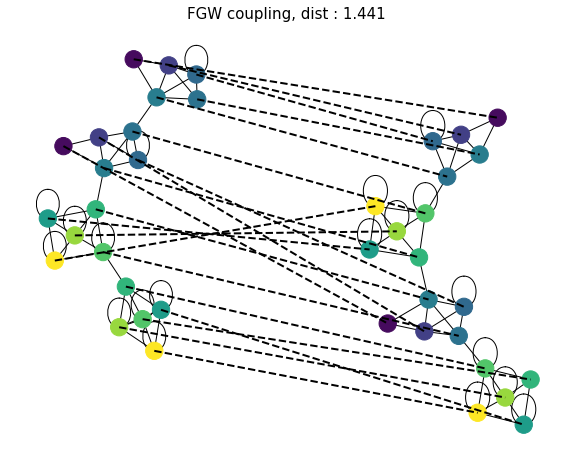

In [13]:
fig=plt.figure(figsize=(10,8))
thresh=0.004
gwdist=Fused_Gromov_Wasserstein_distance(alpha=0.8,features_metric='sqeuclidean')
d=gwdist.graph_d(G1,G2)
plt.title('FGW coupling, dist : '+str(np.round(d,3)),fontsize=15)
draw_transp(G1,G2,gwdist.transp,shiftx=2,shifty=0.5,thresh=thresh,
            swipy=True,swipx=False,with_labels=False,vmin=vmin,vmax=vmax)
plt.show()

We can also plot the GW coupling

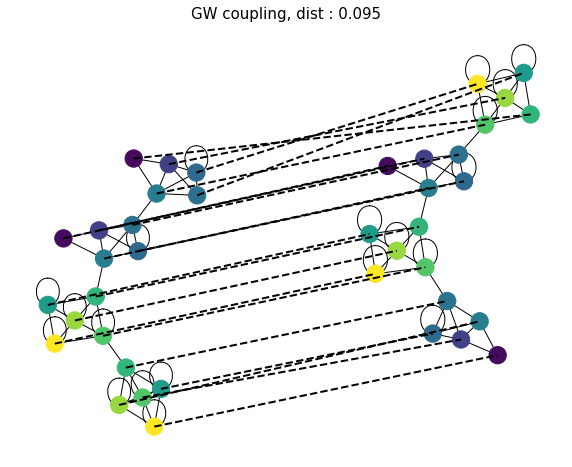

In [14]:
fig=plt.figure(figsize=(10,8))
thresh=0.004
gwdist=Fused_Gromov_Wasserstein_distance(alpha=1,features_metric='sqeuclidean')
d=gwdist.graph_d(G1,G2)
plt.title('GW coupling, dist : '+str(np.round(d,3)),fontsize=15)
draw_transp(G1,G2,gwdist.transp,shiftx=2,shifty=0.5,thresh=thresh,
            swipy=False,swipx=False,with_labels=False,vmin=vmin,vmax=vmax)

plt.show()